<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Data Sourcing and Aquisition 

----

### Data Aquisition Guide:

- [Outline](#requirement)
- [Data Source](#source) 
- [Web-scraping Tools Used:](#webscrape)
    - [Selenium Webdriver](#selenium) 
    - [BeautifulSoup](#beautifulsoup)
- [Preliminary Dataframe](#dataframe)
- [List of Extracted Variables](#variablelist)


In [7]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re, os, time
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import warnings
warnings.simplefilter('ignore')

<a id="source"></a>
### Data Source:
---

#### Mutual Art - Subscription art information site

- Founded in 2008, MutualArt.com is a leading art information website. 
- Its gives access to auction prices, latest industry updates and data on over 300,000 artists.
- Most art auction data is scattered across different sources and usually incomplete. 
- This subscription site has over 3 million recorded auction sales in its database.

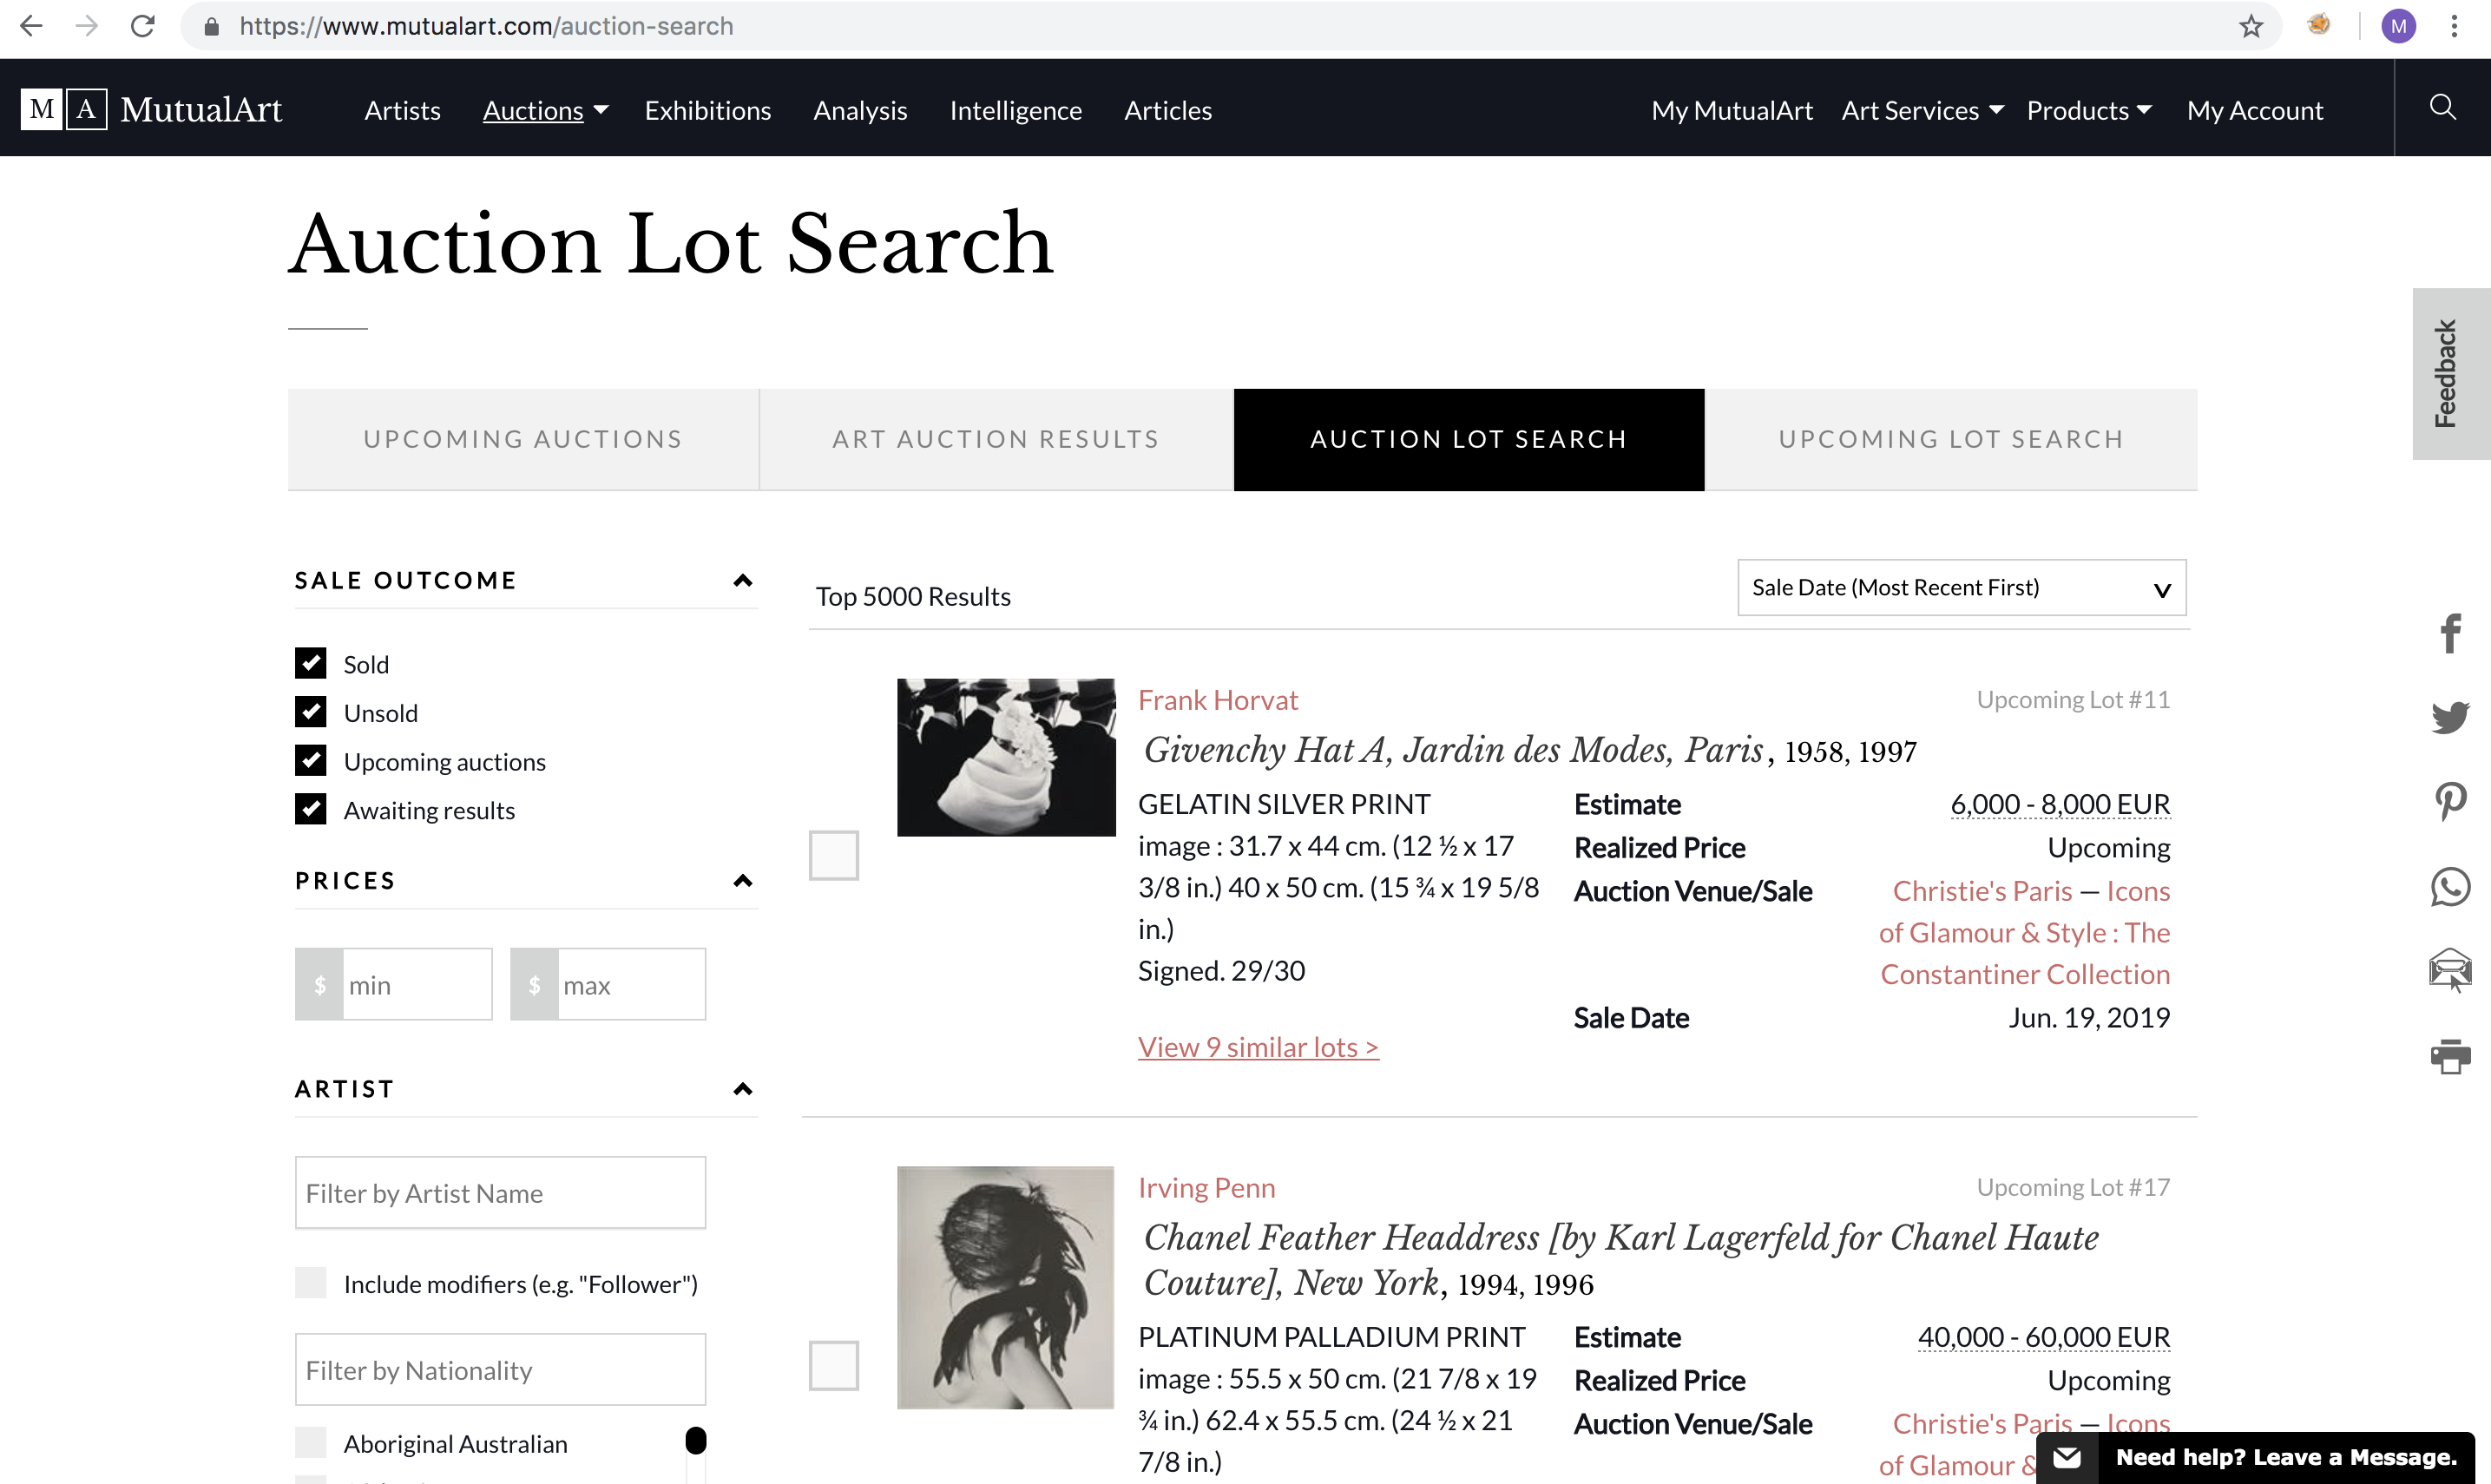

- Search results can be filted by sale outcome, price range, artist, auction house and artwork attributes
- Since the aim is to predict the the realised price of an artwork, I will only be looking at **sold** sale outcomes.
- In addition, since there are many different categories of artwork with different attributes due to time restraint I will be looking specifically at graphics & prints only.
- Reasons for choosing graphics and prints:
    - The price range is more confined.
    - Each graphic/print can come from multiple prints, hence more records of the print being sold

## Webscraping Technique and Tools Used:
<a id="webscrape"></a>

<a id="selenium"></a>

### Using Selenium Webdriver to access and extract information from Mutual Art Platform:
----

**Problem:**

1. MutualArt is a subscription site therefore in order to web-scrape, one needs to login first.
2. The site is an infinte scroll site for loading results in the next page
3. For every search filter, the site will only show the top 5000 results



**Solution:** ... Selenium Webdriver!

- Selenium webdriver allows one to control and automate a web-brower (such as Chrome)

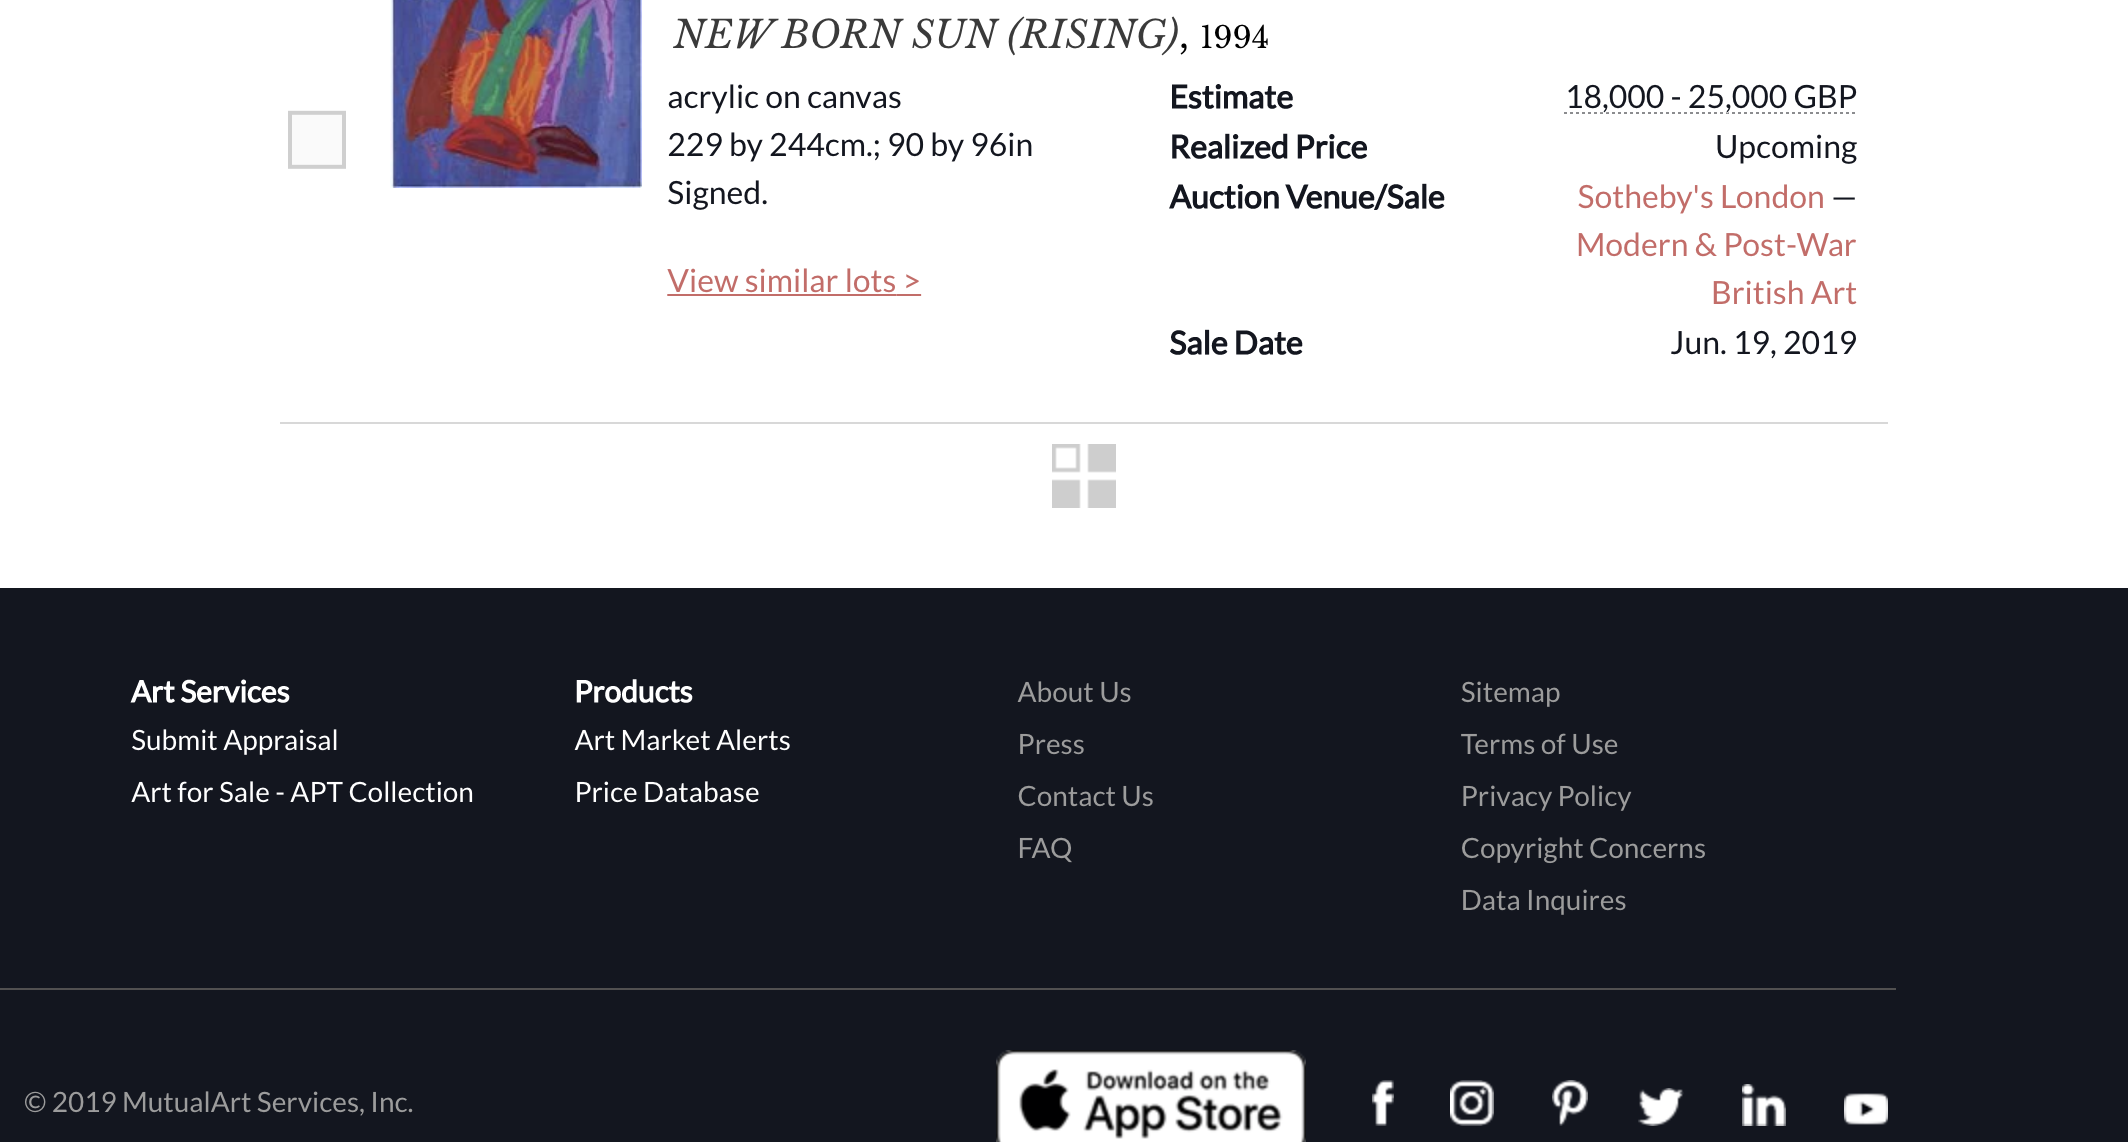

**1. Using selenium to automate logging into the site:**


In [ ]:
#Initializing selenium webdriver using chrome:

login_url = 'https://www.mutualart.com/login?source_page=Auction_Search&cta=LOGIN-%20MENU'
driver = webdriver.Chrome('./chromedriver')
driver.implicitly_wait(1)
driver.get(login_url)

In [ ]:
#Filling in login details:

emailElem = driver.find_element_by_id('login_email')
emailElem.send_keys('ENTER-EMAIL-HERE')
passwordElem = driver.find_element_by_id('login_passw')
passwordElem.send_keys('ENTER-PASSWORD-HERE')

login_button = driver.find_elements_by_xpath('//button[@type="button" and @onclick="login()" and @class="btn btn-1"]')[0]
login_button.click()

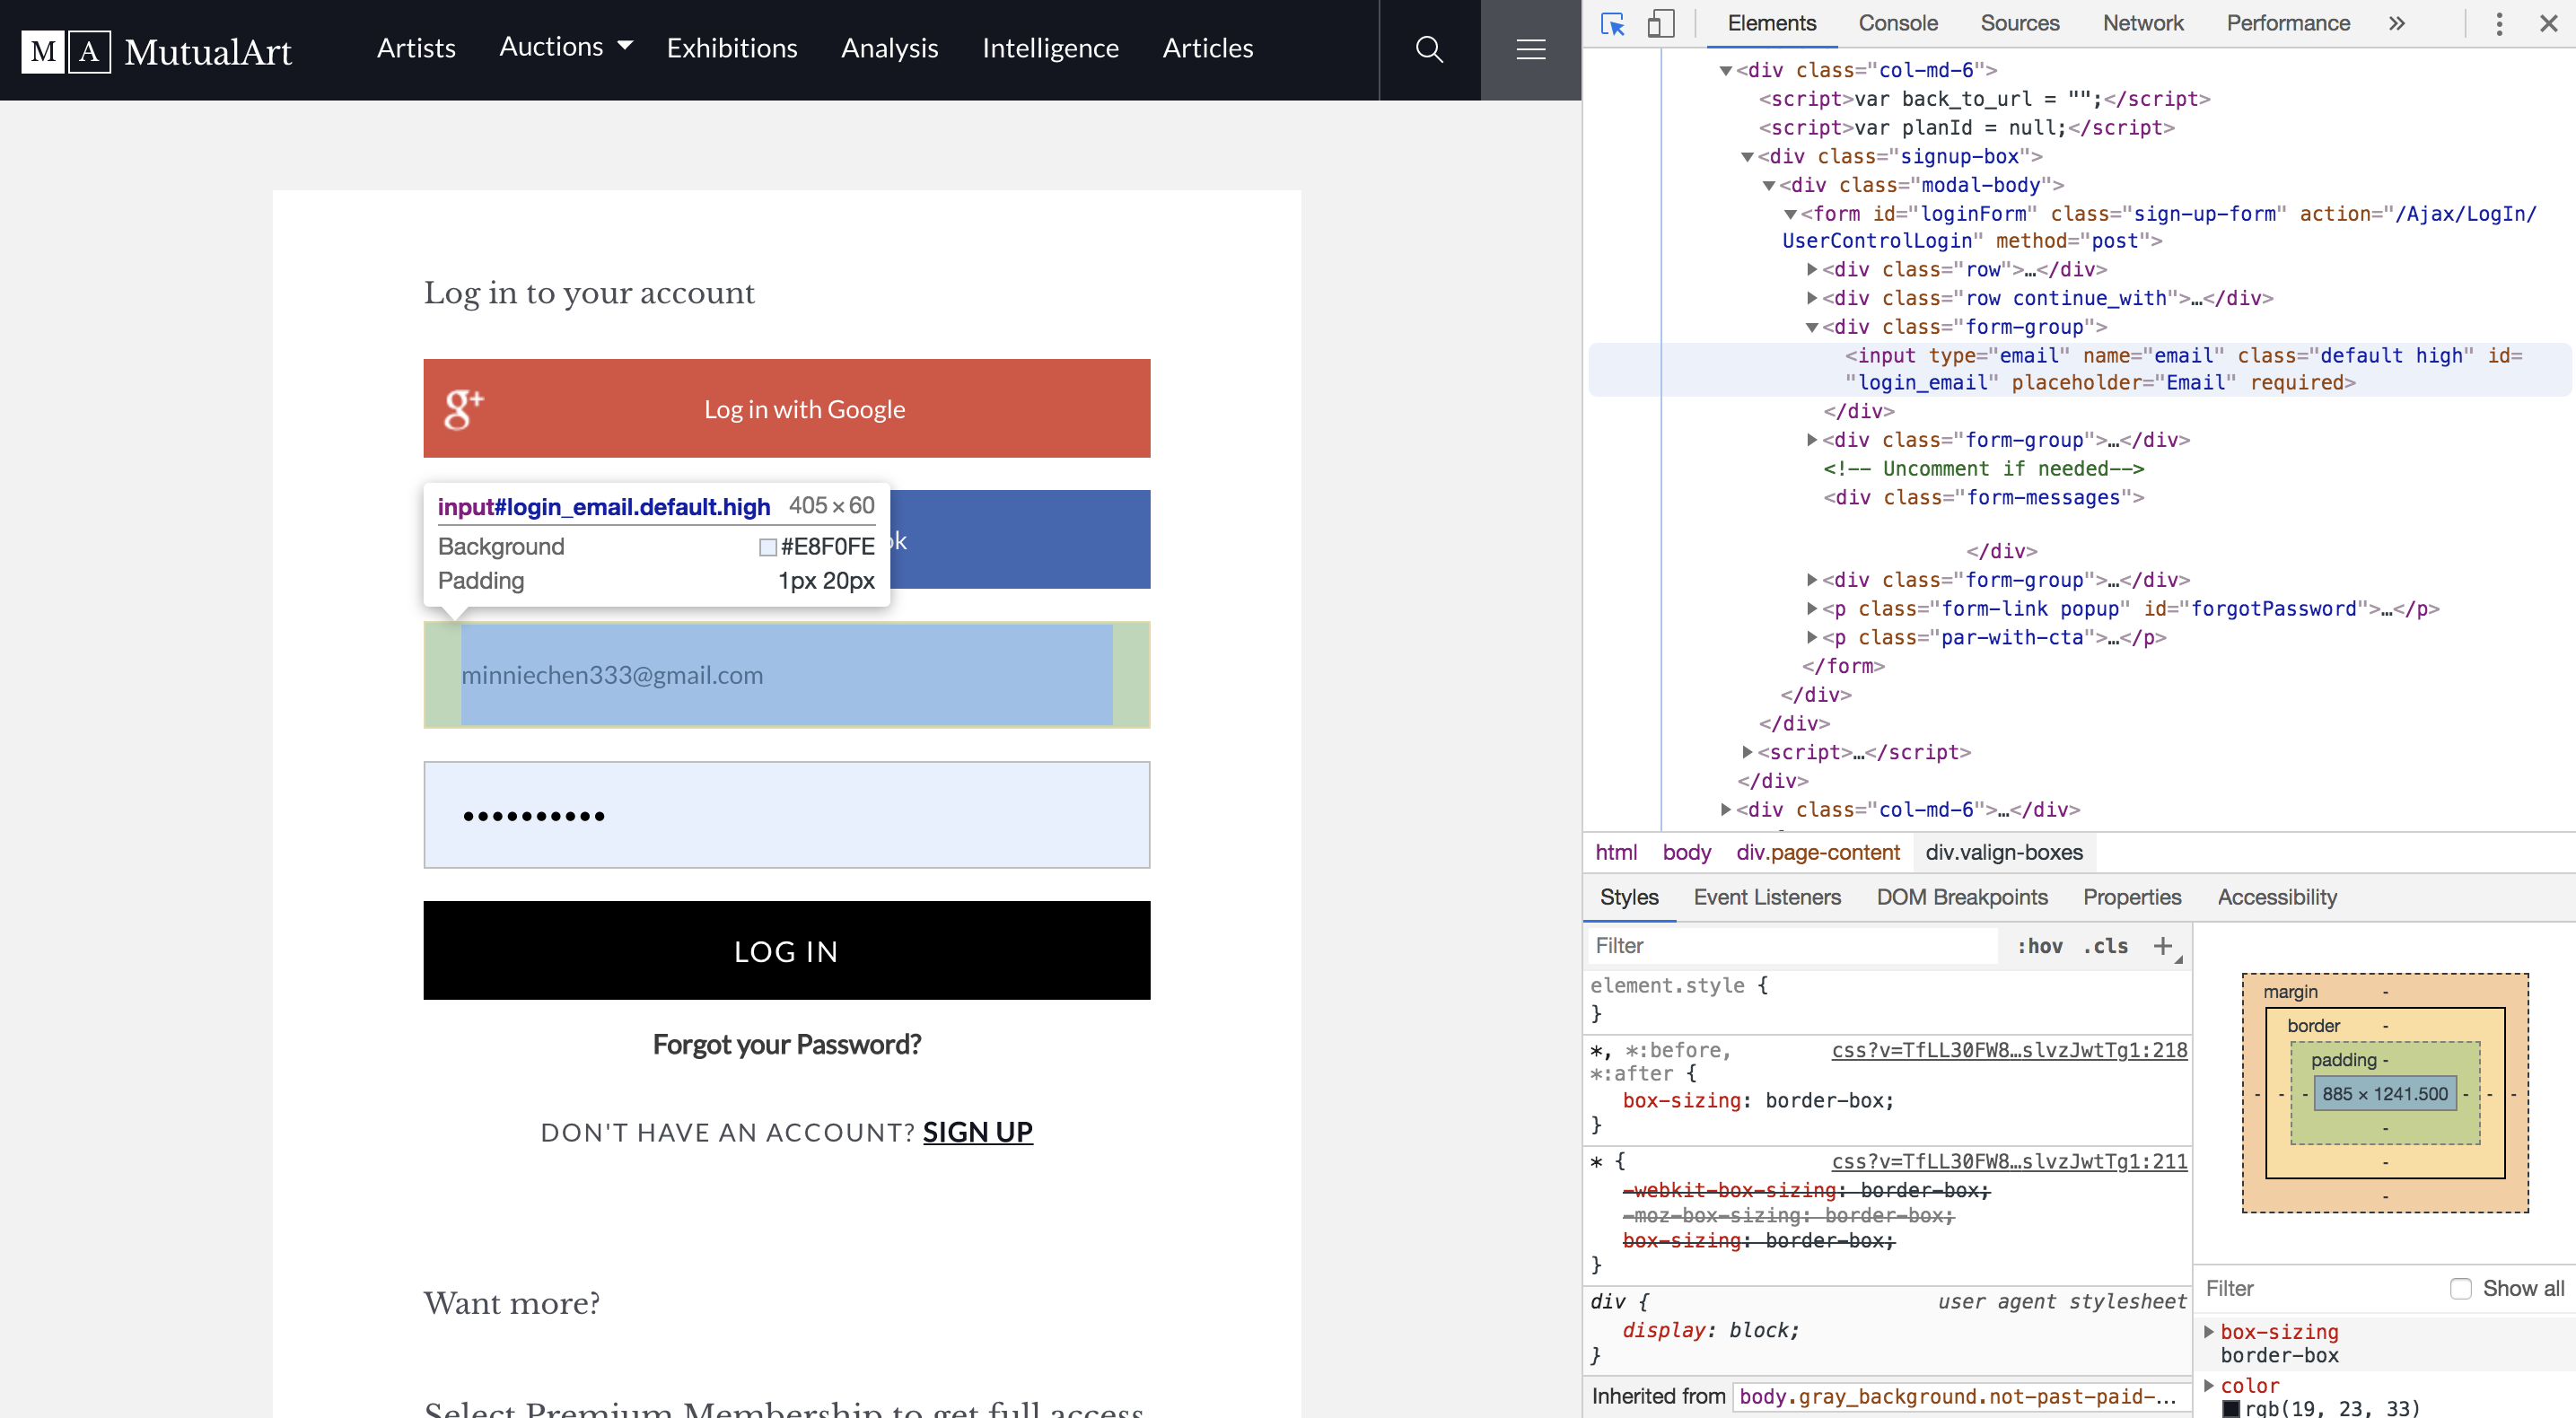

**2. Getting around infinite page scroll:**

In [ ]:
#First to avoid pointless scrolling

#Find number of results for search
#Each page shows 15 results

num_results = driver.find_element_by_id('resultsCount').text
results_count = int(num_results.split(' ')[0])

#Initiates window scroll from point 0 down the length of the height of the window
#pause for 'n' secs to 'sleep' aka let page load

for i in range(1,(round(results_count/15))):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)


**3. Making use of the price range filter:**

- By setting smaller price range filters, more results can be extracted
- Looping through the required price range in smaller ranges optimizes number of data obtained

In [ ]:
    for i in range(min_limit,max_limit,step):     
        web_url = "https://www.mutualart.com/auction-search?Type=Sold&price={}-{}&tags=0EB6EBC43B2996A2&artworkSort=2426EF8DFC0B7B2D".format(i, i+(step-1))

<a id="BeautifulSoup"></a>
### Introducing BeautifulSoup 

---

- Once selenium scrolls to the bottom of the page
- The whole page can be saved as an html script
- This is when the BeautifulSoup tool can be used to make the data acquisition process faster

In [ ]:
html_source = driver.page_source
soup = BeautifulSoup(html_source)

Example code for extracting data:

In [ ]:
def extract_venue(page):
    Venue = []

    for i in page.find_all('div', attrs={'class':'v2__artwork-detail__price-col organization-links'}):
        try:
            Venue.append(i.find('a', attrs = {'itemprop':'author'}).text.strip())
        except:
            Venue.append(np.nan)
    Venues = pd.DataFrame({'Venue': Venue})
    return Venues

<a id="dataframe"></a>
### Combining Selenium and BeautifulSoup to extracted data into a dataframe

----

In [ ]:
def extract_all_data(min_limit, max_limit, step):
    #url for login page of mutualart
    login_url = 'https://www.mutualart.com/login?source_page=Auction_Search&cta=LOGIN-%20MENU'

    #initialise selenium
    driver = webdriver.Chrome('./chromedriver')
    driver.implicitly_wait(1)

    #login via selenium
    driver.get(login_url)
    emailElem = driver.find_element_by_id('login_email')
    emailElem.send_keys('ENTER-EMAIL')
    passwordElem = driver.find_element_by_id('login_passw')
    passwordElem.send_keys('ENTER-PASSWORD')
    login_button = driver.find_elements_by_xpath('//button[@type="button" and @onclick="login()" and @class="btn btn-1"]')[0]
    login_button.click()

    time.sleep(0.5)


    #list of dataframes from each iteration
    results=[]

    for i in range(min_limit,max_limit,step):
        #high to low url         
        web_url = "https://www.mutualart.com/auction-search?Type=Sold&price={}-{}&tags=0EB6EBC43B2996A2&artworkSort=2426EF8DFC0B7B2D".format(i, i+(step-1))

        #low to high url
#         web_url = "https://www.mutualart.com/auction-search?Type=Sold&price={}-{}&tags=0EB6EBC43B2996A2&artworkSort=70F3BA69A7C11779".format(i, i+(step-1))
        #Initialise with url for scraping
        time.sleep(0.5)
        driver.get(web_url)

        time.sleep(2)
        #infinite scroll code:
        num_results = driver.find_element_by_id('resultsCount').text
        
        try:
            results_count = int(num_results.split(' ')[0])
        except:
            results_count = 5000


        scroll_count = results_count/10

        for i in range((round(scroll_count))):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            timepage = 3+i*0.1
            time.sleep(timepage)


        #save page as an html
        html_source = driver.page_source

        #BeautifulSoup magic begins here:
        soup_ = BeautifulSoup(html_source)




        #functions for web-scraping different variables
        title = extract_title(soup_)
        titleurl = extract_title_urls(soup_)
        year = extract_year(soup_)
        artist = extract_artist(soup_)
        artisturl = extract_artist_url(soup_)
        medium = extract_medium(soup_)
        dimension = extract_dimension(soup_)
        signed = extract_sign(soup_)
        similar = extract_similar(soup_)
        estimate = extract_estimate(soup_)
        realised = extract_realised(soup_)
        venue = extract_venue(soup_)
        saledate = extract_saledate(soup_)
        imageurl = extract_imageurl(soup_)


        #combining all the dataframe together via concat joining by the index
        result = pd.concat([title, titleurl, year, artist, artisturl, medium, dimension, signed, similar, estimate, realised,
                           venue, saledate, imageurl], axis=1, join_axes=[title.index])

        results.append(result)

    df = pd.concat(results)
    return df

#### Example of extracted dataframe:

In [15]:
pd.read_csv('./df_5001_6000.csv').drop(columns='Unnamed: 0').head(3)

,Title,Title_url,Year,Artist,Artist_url,Art_medium,Dimensions,Signed,Similar_items,Estimate_Price,Realized_Price,Venue,Sale_date,Image_url
0,Vaque,https://www.mutualart.com/Artwork/Vaque/9EF65B...,1897,Privat Livemont,https://www.mutualart.com/Artist/Privat-Livemo...,"Color lithograph on smooth, cream wove paper",320x500 mm; 12 1/2x19 3/4 inches,No,https://www.mutualart.com/Artwork/Vaque/9EF65B...,NaN,"6,000 USD",Swann Auction Galleries,"Sep. 20, 2012",https://media.mutualart.com/Images/2012_09/19/...
1,Hakone Tonosawa Yuba (The Hot Springs of Tonos...,https://www.mutualart.com/Artwork/Hakone-Tonos...,2001,Utagawa Hiroshige,https://www.mutualart.com/Artist/Utagawa-Hiros...,prints,NaN,No,https://www.mutualart.com/Artwork/Hakone-Tonos...,NaN,"6,000 USD",Freeman's,"May 21, 2004",https://media.mutualart.com/Images/2013_03/01/...
2,Pool made with paper and blue ink for book,https://www.mutualart.com/Artwork/Pool-made-wi...,1980,David Hockney,https://www.mutualart.com/Artist/David-Hockney...,color lithograph,10 1/2 x 9 inches,Signed.992/1000,https://www.mutualart.com/Artwork/Pool-made-wi...,NaN,"6,000 USD","Leslie Hindman Auctioneers, Chicago","Sep. 19, 2005",https://media.mutualart.com/Images/2013_03/20/...


<a id="variablelist"></a>
#### List of Variables Extracted from site:
---

*Title*
- Title of the artwork
- This is pretty clean, no need to work on it

*Title_url*
- URL for clicking into the mainpage of the artwork

*Year*
- Year in which artwork was produced


*Artist*
- Artist who produced the artwork

*Artist_url*
- for extracting more information on the artist


*Art_medium*
- material and type of artwork information


*Dimensions*

- size of the artwork
- Formatted in different metrics, inches, cm, mm and ft 

*Signed*

- Signed by artist or not. 
- Information on print number and total number of prints

*Similar item list*

- url for similar item page

*Estimate_Price*

- estimated price of artwork before auction


*Realized_Price*

- Price in which artwork was successfully sold

*Venue*

- Auction House Venue

*Sale_date*

- Date of Auction sale

*image_url*

- Image jpeg. URL
